In [1]:
# modules
import re
import os
import sys
import itertools
import numpy as np
import pandas as pd
import multiprocessing as mp
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

sys.path.append('../')
from ensemble.model import Ensemble
from baseModels.SVM.model import SVM
from featEngg.online.kmerMethods.models import ngModel,gaangModel

In [2]:
class TEClassification:
    
    def __init__(self,enzseqdata,testenzseqdata,labelfile,trainfeaturefiledirs,testfeaturefiledirs,
                 hyperparamfile,random_seed=None,n_models=17,validation_fraction=0.25):
        
        self.random_seed = random_seed
        self.n_models = n_models
        self.validation_fraction = validation_fraction
        self.test = True if testfeaturefiledirs else False
        
                
        # original data based on which everything is obtained
        df1 = pd.read_csv(enzseqdata,header=None)
        df2 = pd.read_csv(labelfile,header=None)
        self.train_df = df1.merge(df2,on=0)
        
        self.enz_names = self.train_df[0].values
        self.X = self.train_df.iloc[:,1].values
        self.y = self.train_df.iloc[:,-1].values
        
        # training and validation data for general use
        self.X_train, self.X_valid, self.y_train, self.y_valid,self.enz_train,self.enz_valid = train_test_split(self.X, self.y,self.enz_names, test_size=self.validation_fraction, random_state=self.random_seed)
        
        self.label_file = labelfile
        
        # test data
        if self.test:
            self.test_df = pd.read_csv(testenzseqdata,header=None)
            self.testenz_names = self.test_df[0].values
            self.X_test = self.test_df.iloc[:,1].values
        else:
            self.X_test=None
            
        self.df_hyperparam = pd.read_csv(hyperparamfile).set_index('feat_name')
        
        # kmer and gaakmer
        ng = ngModel(self.X_train,self.X_valid,self.X_test)
        gaang = gaangModel(self.X_train,self.X_valid,self.X_test)
        kmernames = ['kmer','gaakmer']
        kmerObjs = [self.get_model_online(ng.Xtrain,ng.Xvalid,self.y_train,self.y_valid,ng.Xtest),self.get_model_online(gaang.Xtrain,gaang.Xvalid,self.y_train,self.y_valid,gaang.Xtest)]

        
        #generate a list of names from the directories
        trainfeatfiles = [d+f.name for d in trainfeaturefiledirs for f in os.scandir(d) if f.name.endswith('.csv.gz')]            
        self.featnames = [f.name.replace('.csv.gz','') for d in trainfeaturefiledirs for f in os.scandir(d) if f.name.endswith('.csv.gz')]
        
        if self.test:
            testfeatfiles = [d+f.name for d in testfeaturefiledirs for f in os.scandir(d) if f.name.endswith('.csv.gz')]
            func_iter = list(zip(trainfeatfiles,self.featnames,testfeatfiles))
            assert [f.name for d in trainfeaturefiledirs for f in os.scandir(d) if f.name.endswith('.csv.gz')]==[f.name for d in testfeaturefiledirs for f in os.scandir(d) if f.name.endswith('.csv.gz')]
            self.objects=list(itertools.starmap(self.get_model_offline,func_iter))

        else:
            # getting all SVM objects together
            func_iter = list(zip(trainfeatfiles,self.featnames))
            self.objects = list(itertools.starmap(self.get_model_offline,func_iter))
            
        self.featnames.extend(kmernames)
        self.objects.extend(kmerObjs)
            
        
        # select only the best models based on training or validation
        self.best_idx,self.best_models = self.select_top_models(self.objects)
        self.best_model_names = np.array(self.featnames)[self.best_idx]
        
        # getting all model predictions together for ensemble
        if not self.test:
            self.all_model_preds = [o.ypredvalid for o in self.best_models]
            self.en = Ensemble(self.all_model_preds,self.y_valid)
            self.precision = precision_score(self.y_valid,self.en.preds,labels=[3],average='micro')
            
        else:
            self.all_model_preds = [o.yhattest for o in self.best_models]
            self.en = Ensemble(self.all_model_preds)
        
        pass
    
    def get_model_online(self,X_train,X_valid,y_train,y_valid,X_test=None):

        if X_train.shape[1]<55:
            pca_components = int(0.75*X_train.shape[1])
        else:
            pca_components=55
            
        obj = SVM(X_train,X_valid,y_train,y_valid,X_test,pca_comp=55,
                           regC=30,kern='rbf',optimize=False,
                           verbose=False,random_seed=self.random_seed)
        
        return obj
    
    
    def get_model_offline(self,featfilename,featname,testfeatfilename=None):
        
        df1 = pd.read_csv(featfilename,header=None)
        df2 = pd.read_csv(self.label_file,header=None)
        df_feat = df1.merge(df2,on=0).set_index(0)
        df_feat_train = df_feat.loc[self.enz_train]
        df_feat_valid = df_feat.loc[self.enz_valid]
        X_train_feat,y_train_feat = df_feat_train.iloc[:,0:-1].values,df_feat_train.iloc[:,-1].values
        X_valid_feat,y_valid_feat = df_feat_valid.iloc[:,0:-1].values,df_feat_valid.iloc[:,-1].values
        
        pca_components = self.df_hyperparam.loc[featname,'pca_comp']
        regCparam = self.df_hyperparam.loc[featname,'regC']
        kernparam = self.df_hyperparam.loc[featname,'kernel']
        
        if X_train_feat.shape[1]<pca_components:
            raise ValueError('Wrong Hyper Parameter')
            
        if self.test:
            df_feat_test = pd.read_csv(testfeatfilename,header=None).set_index(0)
            X_test_feat = df_feat_test.loc[self.testenz_names].values
            if X_train_feat.shape[1] != X_test_feat.shape[1]:
                print(featfilename)
        else:
            X_test_feat=None
                
        obj = SVM(X_train_feat,X_valid_feat,y_train_feat,y_valid_feat,X_test_feat,pca_comp=pca_components,
                           regC=regCparam,kern=kernparam,optimize=False,
                           verbose=False,random_seed=self.random_seed)
        return obj
        
    def select_top_models(self,Os):
        o_valid_accs = [o.acc_valid for o in Os] if self.test else [o.acc_train for o in Os] 
        sorted_idx = np.argsort(o_valid_accs)[::-1]
        best_idx = sorted_idx[:self.n_models]
        return best_idx,np.array(Os)[best_idx]
        

In [3]:
%%time
if __name__=='__main__':
    # Sequence and label files 
    enz_file = '../data/seq/EnzymeSequence.csv'
    label_file = '../data/label/EnzymeLabelsMultiClass.csv'
    
    testenz_file = '../data/seq/TestEnzymeSequence.csv'
    
    hyperparam_file = '../data/results/HyperParameterOptimization/IndHPOpt.csv'

    # Feature dir for iFeature,kernel,pssm 
    ifeatdatadir = '../featEngg/offline/ifeatMethods/data/featvec/trainfiles/'
    kerneldatadir = '../featEngg/offline/kernelMethods/data/featvec/trainfiles/'
    pssmdatadir = '../featEngg/offline/pssmMethods/data/featvec/trainfiles/'

    ifeattestdatadir = '../featEngg/offline/ifeatMethods/data/featvec/testfiles/'
    kerneltestdatadir = '../featEngg/offline/kernelMethods/data/featvec/testfiles/'
    pssmtestdatadir = '../featEngg/offline/pssmMethods/data/featvec/testfiles/'

    trainfeatdirs = [ifeatdatadir,kerneldatadir,pssmdatadir]
    testfeatdirs = [ifeattestdatadir,kerneltestdatadir,pssmtestdatadir]


    te = TEClassification(enz_file,testenz_file,label_file,trainfeatdirs,testfeatdirs,hyperparam_file,random_seed=17)
    te_notest = TEClassification(enz_file,None,label_file,trainfeatdirs,None,hyperparam_file,random_seed=17)
    
    def multi_func(rs):
        te_i = TEClassification(enz_file,None,label_file,trainfeatdirs,None,hyperparam_file,random_seed=rs)
        return te_i.precision,te_i.en.acc    
    
    pool = mp.Pool(mp.cpu_count())

    
    
    
    metrics = list(pool.map(multi_func,range(10000)))
    


CPU times: user 16.7 s, sys: 447 ms, total: 17.2 s
Wall time: 51min 47s


In [4]:
prec = [metr[0] for metr in metrics]
accs = [metr[1] for metr in metrics]

In [5]:
print(min(prec),np.mean(prec),max(prec),np.std(prec))

0.375 0.8880404066551784 1.0 0.08814205461849389


In [6]:
print(min(accs),np.mean(accs),max(accs),np.std(accs))

0.4827586206896552 0.7934206896551724 1.0 0.06986410590351799


In [7]:
def saveResults(filename):
    with open('../data/results/EnsembleResults/'+filename,'w') as f:
        for rs,score in enumerate(metrics):
            f.write(str(rs)+','+str(score[0])+','+str(score[1])+'\n')
    return

In [8]:
saveResults('MultiClassEnsembleIndOpt.csv')

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([1.000e+00, 0.000e+00, 1.800e+01, 4.300e+01, 1.550e+02, 4.050e+02,
        1.130e+03, 2.208e+03, 3.497e+03, 2.543e+03]),
 array([0.375 , 0.4375, 0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125,
        0.875 , 0.9375, 1.    ]),
 <a list of 10 Patch objects>)

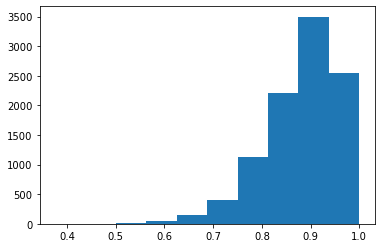

In [10]:
plt.hist(prec)

(array([   7.,   61.,  117.,  298., 1738., 1590., 3812., 1390.,  938.,
          49.]),
 array([0.48275862, 0.53448276, 0.5862069 , 0.63793103, 0.68965517,
        0.74137931, 0.79310345, 0.84482759, 0.89655172, 0.94827586,
        1.        ]),
 <a list of 10 Patch objects>)

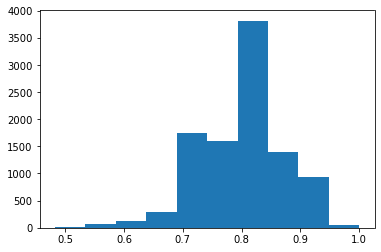

In [11]:
plt.hist(accs)

In [12]:
np.median(accs),np.median(prec)

(0.7931034482758621, 0.9090909090909091)

# Model Predictions

In [13]:
testenzmapfile = '../data/TestEnzymeNameMap.csv'
testenznamemapdf = pd.read_csv(testenzmapfile,header=None)
test_enz_mapdict = dict(zip(testenznamemapdf[0],testenznamemapdf[1]))

In [14]:
with open('../data/results/TestSetPredictionsIndOpt.txt','w') as f:
    f.write(f'Model Name: Ensemble')
    f.write('\n')
    for name,val in zip(te.testenz_names,te.en.preds):
        f.write(f'{test_enz_mapdict[name]} {"-"*5}> {str(val)}')
        f.write('\n')
    f.write(f'{"-"*50}')
    f.write('\n')
    for index,model_name in enumerate(te.featnames):
        f.write(f'Model Name: {model_name}')
        f.write('\n')
        for name,val in zip(te.testenz_names,te.objects[index].yhattest):
            f.write(f'{test_enz_mapdict[name]} {"-"*5}> {str(val)}')
            f.write('\n')
        f.write(f'{"-"*50}')
        f.write('\n')